In [1]:
import os
import re
import math
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.porter import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import nltk
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn import model_selection, feature_extraction, naive_bayes, pipeline, manifold, preprocessing, feature_selection,metrics
from sklearn.svm import LinearSVC
from sklearn import pipeline

Playing with the written statements from the Expressive Writing study. 

sources:
https://www.kaggle.com/dskswu/topic-modeling-bert-lda - topic modeling bert+lda

Specify path to input directory and read in files.

In [2]:
home = 1
if home:
    infiledir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\Processed_2"
    writing_dir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\writing_data\statements"
else:
    infiledir = r"P:\EW_analysis\analysis\Processed_2"
    writing_dir = r"P:\EW_analysis\analysis\writing\writing_data"



In [3]:
for dirname, _, filenames in os.walk(writing_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# standard expressive writing files
ew_files = [f for f in filenames if 'T1' in f]
# expressive writing + reinterpretation
ewre_files = [f for f in filenames if 'T2' in f]
# control writing 
ctr_files = [f for f in filenames if 'T3' in f]


P:\EW_analysis\analysis\writing\writing_data\classification_sunjeev.csv
P:\EW_analysis\analysis\writing\writing_data\classify_statements.csv
P:\EW_analysis\analysis\writing\writing_data\classify_statements_wi.csv
P:\EW_analysis\analysis\writing\writing_data\writing_df.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T1_Day1.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T1_Day2.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T1_Day3.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T1_Day4.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T2_Day1.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T2_Day2.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T2_Day3.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T2_Day4.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T3_Day1.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T3_Day2.csv
P:\EW_analysis\analysis\writing\writing_data\Writing_T3_Day3.csv
P:\EW_analys

utils

In [4]:
def flatten_lists(token_list, group_inds):
    """
    Flatten list of lists.

    Parameters
    ----------
    token_list: list
        list of tokens to operate on
    group_inds:  index
        indices (of dataframe) to operate on

    Returns
    -------
        flattened list.
    """
    list_flattened = [item for sublist in token_list[group_inds[0]:group_inds[-1]] for item in sublist]
    return list_flattened

def get_diaries(directory,filenames,group_name):
    """ 
    read in files from each group/day of writing
    
    Parameters
    ----------
    directory: str
        path to input directory, list of filenames, condition name (EW, EWRE or CTR)
    filenames: list
        list of input filenames
    group_name: str
        Group name  (EW , EWRE, CTR)
    
    Returns
    -------
        list of lists of data from all days of writing for the specified group.
    """
    all_files = []
    for i,name in enumerate(filenames):
        diary_df = pd.read_csv(os.path.join(directory,name),skiprows = [0,2])
        # retain only records of people who finished the survey
        diary_df = diary_df.loc[diary_df.Progress==100,:]
        # what day of writing were they on
        diary_df['day'] = i+1
        diary_df['Group'] = group_name
        writing_col = diary_df.filter(like = 'Please use the box below').columns[0]
        diary_df = diary_df.rename(columns = {writing_col: 'writing'})
        id_col = diary_df.filter(like = 'participant ID').columns[0]
        diary_df = diary_df.rename(columns = {id_col: 'id'})
        all_files.append(diary_df)
    return all_files

def read_files(infiles):
    """
    convert list of lists to dataframe.

    Parameters
    ----------
    infiles:    list
        list of input files to operate on

    Returns
    -------
        Dataframe of concatenated input.
    """
    all_df = pd.concat([pd.DataFrame(infiles[0]), pd.DataFrame(infiles[1]),pd.DataFrame(infiles[2]),pd.DataFrame(infiles[3])])
    return all_df

def counter_cosine_similarity(c1, c2):
    """
    Calculate cosine similarity.
    source: https://stackoverflow.com/questions/14720324/compute-the-similarity-between-two-lists

    Parameters
    ----------
    c1, c2: list
        lists to compare

    Returns
    -------
        cosine similarity score 
    """
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

def get_feature_corr(labels_train,features,ngram_type, tfidf_vec):
    """ 
    Get the terms most correlated with each group.

    Parameters
    ----------
    labels_train: pd.Series
        series containing training data labels
    features: scipy compressed sparse column matrix
        sparse matrix of features
    ngram type: str
        unigrams, bigrams or trigrams
    tfidf_vec:  tf idf vectorizer 
        tf idf vectorizer (sklearn)

    Returns
    -------
    list of correlated features
    
    """
    labels =  pd.Categorical(y_train).codes
    features_chi2 = feature_selection.chi2(features,labels)
    features = features.toarray()
    indices = np.argsort(features_chi2[0])
    print(indices)
    feature_names = np.array(vectorizer_tf_idf.get_feature_names())[indices]
    if ngram_type == 'unigrams':
        ngrams = [f for f in feature_names if len(f.split())==1]
    elif ngram_type == 'bigrams':
        ngrams = [f for f in feature_names if len(f.split())==2]
    else:
        ngrams = [f for f in feature_names if len(f.split())==3]
    return ngrams     

    

preprocessing

In [5]:

from nltk.stem.porter import PorterStemmer
import re
import nltk
from nltk.tokenize import word_tokenize
import pkg_resources
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# normalization
def func_norm(s):
    """
    Perform some basic normalisation operations.

    Parameters
    ----------
    s:  str
        text to operate on
    
    Returns
    -------
        Normalised string
    
    """
    s = s.lower() # lower case
    # letter repetition (>2)
    s  = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # non word repetition
    s = s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # noise text
    s = re.sub(r' ing ', ' ', s)
    # phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()

def func_punc(w_list):
    """
    Remove non-alphabet characters. Includes punctuation.

    Parameters
    ----------
    w_list: list
        list of tokens to be processed
    
    Returns
    -------
        list without non-alphabet characters
    """
    return [word for word in w_list if word.isalpha()]

def func_stopf(w_list):
    """
    Remove stop words

    Parameters
    ----------
    w_list: list
        list of tokens to be processed
    
    Returns
    -------
        list without stop words
    """
    stop_words = set(stopwords.words('english'))
    w_list  = [f for f in w_list if f not in stop_words]
    return w_list

# stemming
pstem = PorterStemmer()

def func_stem(w_list):
    """
    stem word list

    Parameters
    ----------
    w_list: list
        word list for stemming

    Returns
    -------
        stemmed word list 
    """
    sw_list = [pstem.stem(w) for w in w_list]
    return sw_list

# selecting nouns
def func_noun(w_list):
    """
    in: word list to be processed
    out: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']

# spell checker/typo correction
def func_spell(w_list):
    """
    in: word list to be processed
    out: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            w_list_fixed.append(suggestions[0].term)
        else:
            pass
    return w_list_fixed

def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw texts

    Parameters
    ----------
        rw: str
            sentence to be processed

    Returns
    -------
        sentence level pre-processed text
    """
    s = func_norm(rw)

    return s



def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences.
    
    Parameters
    ----------
    s:  str
        sentence to be processed
    
    Returns
    -------
        word level pre-processed text
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = func_punc(w_list)
    w_list = func_noun(w_list)
   # w_list = func_spell(w_list)
    w_list = func_stem(w_list)
    w_list = func_stopf(w_list)

    return w_list

def preprocess(docs):
    """
    Preprocess the data.

    Parameters
    ----------
    docs: list
        list of documents to be preprocessed
    
    Returns
    -------
        Preprocessed sentences, tokens
    """
    print('Preprocessing raw texts ...')
    #n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    #samp = np.random.choice(n_docs)
    for i in range(0, len(docs)):
        sentence = preprocess_sent(docs.iloc[i])
        token_list = preprocess_word(sentence)
        if token_list:
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(writing_df.writing) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    return sentences, token_lists

Read in the diary files and compile them into a single dataframe.

In [6]:
all_ew = get_diaries(writing_dir, ew_files,'EW')
ew_df = read_files(all_ew)
all_ewre = get_diaries(writing_dir, ewre_files,'EWRE')
ewre_df = read_files(all_ewre)
all_ctr = get_diaries(writing_dir, ctr_files,'CTR')
ctr_df = read_files(all_ctr)
writing_df = pd.concat([ew_df,ewre_df,ctr_df])

# save if needed
save = 0
if save:
    writing_df.to_csv(os.path.join(writing_dir, 'writing_df.csv'))


Check whether we have roughly the same number of statements in each condition. We sort of know this is true, but nice to have a quick visual confirmation.

[Text(0, 0.5, 'Number of statements'), Text(0.5, 1.0, 'Statements per Group')]

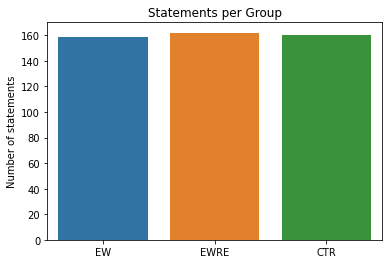

In [7]:
sns.barplot(x = writing_df.Group.unique(), y = [len(ew_df),len(ewre_df),len(ctr_df)]).set(ylabel = 'Number of statements', title = 'Statements per Group')

We'll now have a look at the top 50 words in each group before doing any preprocessing on the text.

Text(0.5, 1.0, 'CTR')

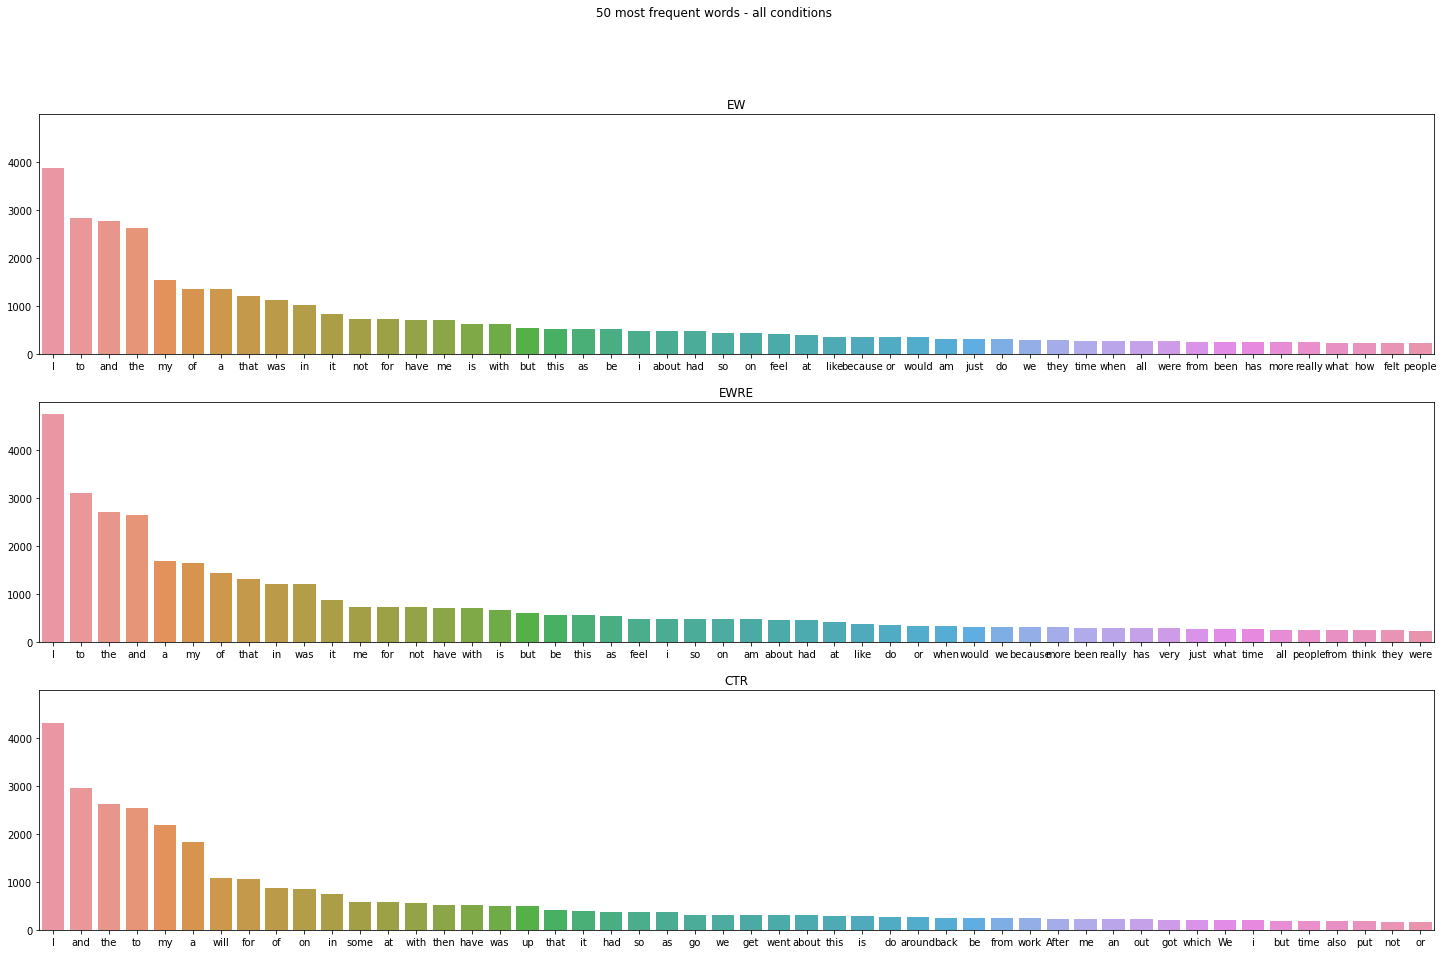

In [8]:
ew_words = writing_df.loc[writing_df.Group == 'EW','writing'].str.split(expand=True).unstack().value_counts()
ewre_words = writing_df.loc[writing_df.Group == 'EWRE','writing'].str.split(expand=True).unstack().value_counts()
ctr_words = writing_df.loc[writing_df.Group == 'CTR', 'writing'].str.split(expand = True).unstack().value_counts()

fig, axes = plt.subplots(3, 1, figsize=(25,15), sharey=True)
fig.suptitle('50 most frequent words - all conditions')

# EW
sns.barplot(ax=axes[0], x=ew_words.index[:50], y=ew_words[:50])
axes[0].set_title('EW')

# EWRE
sns.barplot(ax=axes[1], x=ewre_words.index[:50], y=ewre_words[:50])
axes[1].set_title('EWRE')

# CTR
sns.barplot(ax=axes[2], x=ctr_words.index[:50], y=ctr_words[:50])
axes[2].set_title('CTR')

Even without having done any preprocessing, we can tell there is a difference between the active and control conditions. The word 'feel' makes the top 50 for both EW and EW+RE, but not for CTR, as does the word 'because'. 'Not' is also near the top of the list in both EW and EW+RE, whilst being last on the list of top 50 words in CTR. We will now do some preprocessing and then have another look.

In [9]:
sentences, token_lists = preprocess(writing_df.writing)

Preprocessing raw texts ...
Preprocessing raw texts. Done!


We now draw up the same plot as before, but this time we look at the list of words for each group, from all days of writing.

In [10]:
writing_df = writing_df.reset_index(drop = False)
ew_inds = writing_df[writing_df.Group=='EW'].index
ewre_inds = writing_df[writing_df.Group == 'EWRE'].index
ctr_inds = writing_df[writing_df.Group =='CTR'].index

ew_flattened = flatten_lists(token_lists,ew_inds)
ewre_flattened = flatten_lists(token_lists,ewre_inds)
ctr_flattened = flatten_lists(token_lists,ctr_inds)

Text(0.5, 1.0, 'CTR')

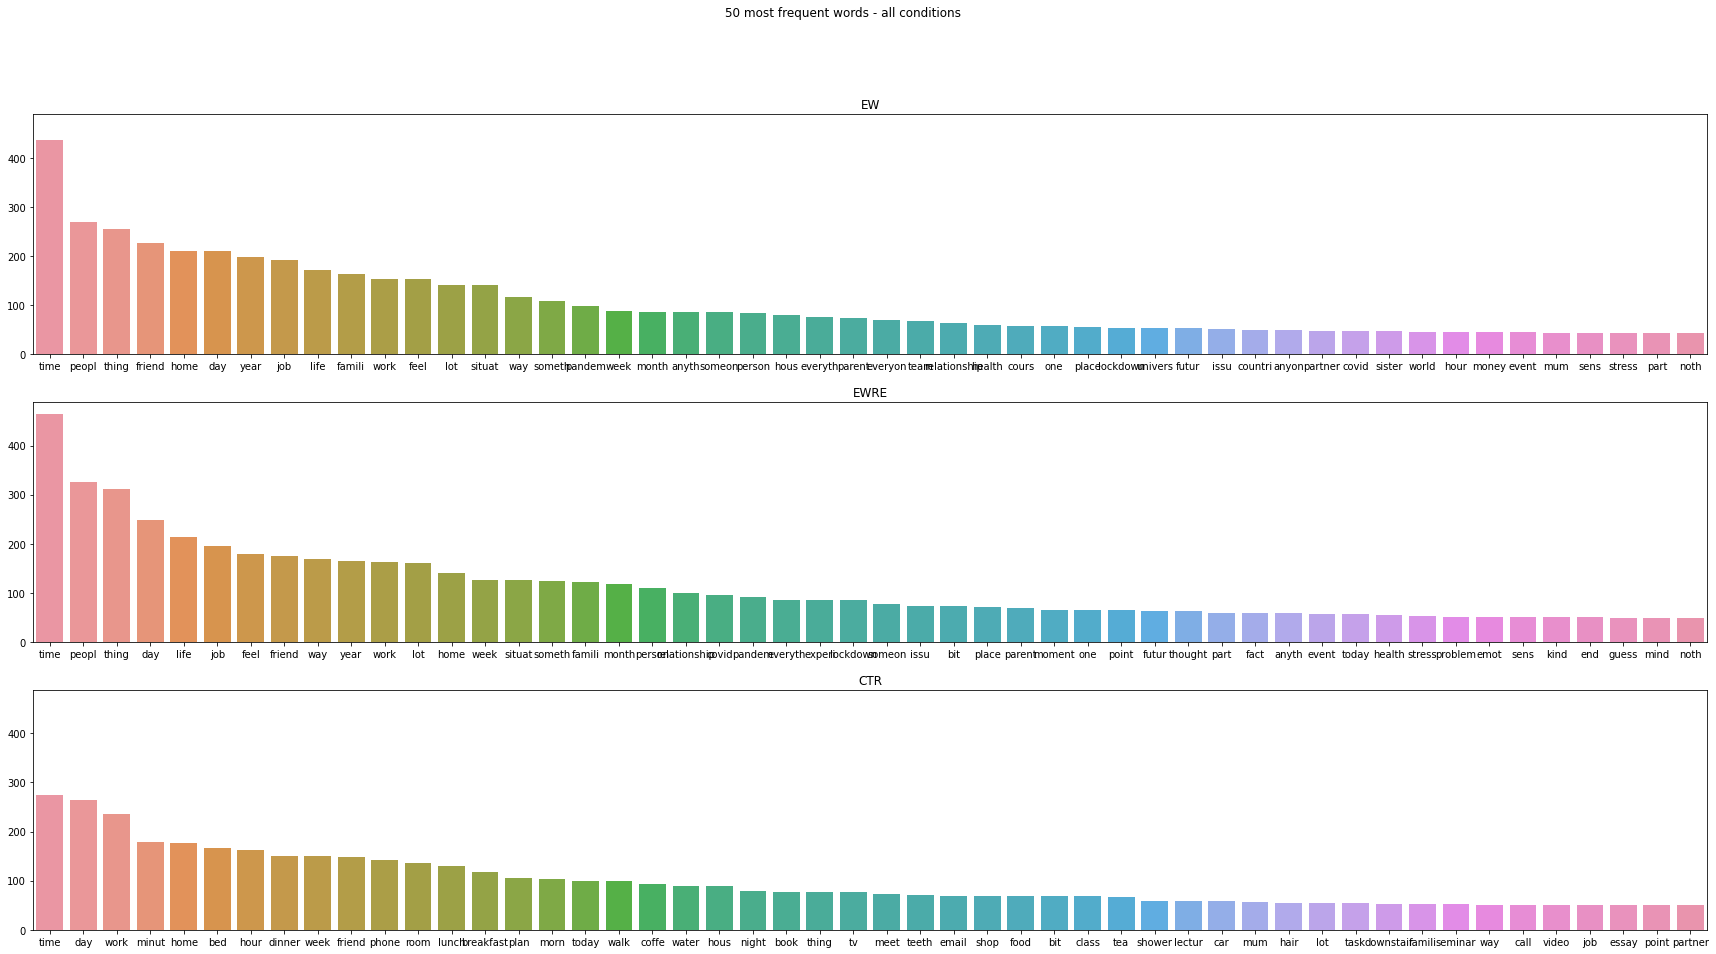

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(30,15), sharey=True)
fig.suptitle('50 most frequent words - all conditions')

# EW
sns.barplot(ax=axes[0], x=pd.Series(ew_flattened).value_counts().index[:50], y=pd.Series(ew_flattened).value_counts()[:50])
axes[0].set_title('EW')

# EWRE
sns.barplot(ax=axes[1], x=pd.Series(ewre_flattened).value_counts().index[:50], y=pd.Series(ewre_flattened).value_counts()[:50])
axes[1].set_title('EWRE')

# CTR
sns.barplot(ax=axes[2], x=pd.Series(ctr_flattened).value_counts().index[:50], y=pd.Series(ctr_flattened).value_counts()[:50])
axes[2].set_title('CTR')

As we can see, the plot has changed quite a bit, and we have a more informative mix of words, rather than just a lot of stop words.
We'll now check how similar the different writing conditions are in terms of the words used. To do this, we calculate the cosine similarity.

In [12]:
# calculate cosine similarity between control and each active writing group/between the two active groups

ew_ctr = counter_cosine_similarity(Counter(ew_flattened), Counter(ctr_flattened))
ewre_ctr = counter_cosine_similarity(Counter(ewre_flattened), Counter(ctr_flattened))
ew_ewre = counter_cosine_similarity(Counter(ew_flattened), Counter(ewre_flattened))

print('The similarity between EW and CTR is: ', ew_ctr)
print('The similarity between EWRE and CTR is: ', ewre_ctr)
print('The similarity between EW and EWRE is: ', ew_ewre)

The similarity between EW and CTR is:  0.5906582452939056
The similarity between EWRE and CTR is:  0.5762576685871926
The similarity between EW and EWRE is:  0.9594697351999425


These numbers look good in terms of comparing active and control conditions, but not so great in terms of comparing the two active conditions. Not totally unexpected though, given that the instructions are similar and we have no real reason to believe that they should differ on word content. 

In [13]:
# assemble cleaned text into a single string - want to operate on the preprocessed text rather than the original.
# need to double-check that stop word removal is appropriate for task.
writing_df['writing_cleaned'] = [' '.join(f) for f in token_lists]

# split into training and test data sets
wrdf_train,wrdf_test = model_selection.train_test_split(writing_df, test_size = 0.3,random_state = 35, stratify = writing_df.Group)

# TF-IDF vectorizer:
vectorizer_tf_idf = feature_extraction.text.TfidfVectorizer(sublinear_tf = True, ngram_range = (1,1))

corpus = wrdf_train['writing_cleaned']
features = vectorizer_tf_idf.fit_transform(corpus)
y_train = wrdf_train.Group
dic_vocabulary = vectorizer_tf_idf.vocabulary_
feature_names = vectorizer_tf_idf.get_feature_names()



In [14]:
ngrams = get_feature_corr(y_train,features,'unigrams',vectorizer_tf_idf)

[  99 2310 1582 ... 1909  910  385]


Let's see whether we can correctly classify the statements in the hold-out (test) portion of the data set. We'll try a couple of different classifiers, starting with linear support vector classification.

In [15]:
classifier = LinearSVC(C=1.0, class_weight="balanced")
tf_idf = pipeline.Pipeline([('tfidf', vectorizer_tf_idf),("classifier", classifier)])
     
tf_idf.fit(wrdf_train.writing_cleaned, y_train)
X_test = wrdf_test['writing_cleaned']
predicted_lsvm = tf_idf.predict(X_test)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'CTR'), Text(0, 1.5, 'EW'), Text(0, 2.5, 'EWRE')])

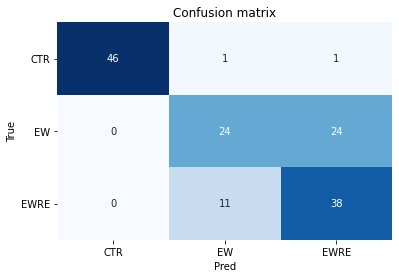

In [16]:
# Plot the confusion matrix.
y_test = wrdf_test['Group']
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
cm = metrics.confusion_matrix(y_test, predicted_lsvm)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

Try Naive Bayes

In [17]:
classifier = naive_bayes.MultinomialNB()

tf_idf_nb = pipeline.Pipeline([('tfidf_nb', vectorizer_tf_idf),("classifier", classifier)])
     
tf_idf_nb.fit(wrdf_train.writing_cleaned, y_train)
X_test = wrdf_test['writing_cleaned']
predicted_nb = tf_idf_nb.predict(X_test)
predicted_prob_nb = tf_idf_nb.predict_proba(X_test)

Accuracy: 0.71
Auc: 0.89
Detail:
              precision    recall  f1-score   support

         CTR       1.00      0.94      0.97        48
          EW       0.65      0.35      0.46        48
        EWRE       0.55      0.84      0.67        49

    accuracy                           0.71       145
   macro avg       0.74      0.71      0.70       145
weighted avg       0.73      0.71      0.70       145



(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'CTR'), Text(0, 1.5, 'EW'), Text(0, 2.5, 'EWRE')])

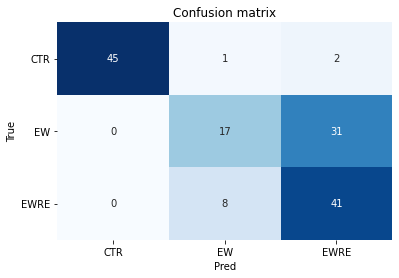

In [18]:

y_test = wrdf_test['Group']
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
# Summary of Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted_nb)
auc = metrics.roc_auc_score(y_test, predicted_prob_nb, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted_nb))
    
# Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted_nb)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)


In [58]:
from lime import lime_text

# select an observation
i = 16
txt_instance = wrdf_test["writing_cleaned"].iloc[i]
# get true and predicted value
print("True:", y_test.iloc[i], "--> Pred:", predicted_nb[i], "| Prob:", round(np.max(predicted_prob_nb[i]),2))
# show explanation - can't change the background colour??
explainer = lime_text.LimeTextExplainer(class_names= np.unique(wrdf_train['Group']))
explained = explainer.explain_instance(txt_instance, tf_idf_nb.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: EW --> Pred: EWRE | Prob: 0.5
